# 7.2 Visualizing Higher Dimensions

By this point, we hope we've convinced you how important it is to visualize your data. While summary statistics are helpful, it doesn't provide us with a good grasp of what the entire dataset looks like. In two dimension, we can use a 2-D scatter plot. In three dimension, we can use a 3-D scatter plot. But what if we have more than three dimensions? This chapter talks about how we can visualize data that is beyond 3 dimensions.

## Goal of Visualizing Higher Dimensions

>"I am a Tralfamadorian, seeing all time as you might see a stretch of the Rocky Mountains. All time is all time. It does not change. It does not lend itself to warnings or explanations. It simply is." 
>
>-Kurt Vonnegate in "Slaughterhour-Five"

We unfortunately are not Tralfamadorians, instead we are three dimensional beings who can't visually see a fourth dimension like its a location on the Rocky Mountains. However, this doesn't mean that the fourth dimension is meaingless to us. We can derive a lot of understand from understanding the higher dimensions. The problem is, we can't it and thus we can't plot it. 

Fortunately, very clever mathematicians throughout history has invented techniques to allow us to simulate what the higher dimension would look like. The rest of the section will discuss these techniques.

## Using Size and Color

This is more of a review from previous sections but one way to visualize more dimensions is by using the size and color attributes of your scatter plots. This is rather intuitive. 

In [0]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import altair as alt

df_bordeaux = pd.read_csv("http://dlsun.github.io/pods/data/bordeaux.csv")

alt.Chart(df_bordeaux).mark_circle().encode(
    alt.X('age',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('sep',
        scale=alt.Scale(zero=False)
    ),
    color="summer",
    size="win"
)

alt.Chart(...)

I am sure you can see the limitations of this method: you can only go up for 4 dimensions (5 if you use a 3-D scatter plot). This is still worth mentioning as sometimes, this may be all you need. 

For higher dimensions, we should consider either feature selection or feature reduction. 

## Feature Selection 

If we want to compress 10 dimensions worth of data into 2 dimensions, we're bound to lose some detail during that compression. We can measure how much detail we kept at the end with the explained variance ratio which gives the percentage of variance/detail we kept after the compression. The higher the ratio, the more variance and detail we kept. 

One way very simple, almost trivial, way to only visualize higher dimensional data is to only plot the two dimensions that explains the most variation in the data. 

In [0]:
sclr = StandardScaler()
df_bordeaux = pd.DataFrame(sclr.fit_transform(df_bordeaux.dropna()), columns=df_bordeaux.columns)

X = df_bordeaux.drop("price", axis=1)
y = df_bordeaux["price"]

reg = LinearRegression()
reg.fit(X, y)

scores = pd.Series(dtype=float, name="R^2 Values")
for column in X.columns: 
    reg = LinearRegression()
    reg.fit(X[[column]], y)
    scores[column] = reg.score(X[[column]], y)

scores.sort_values(ascending=False)

summer    0.343538
sep       0.323582
age       0.206936
year      0.206936
har       0.199621
win       0.053456
Name: R^2 Values, dtype: float64

As we can see above, average summer temperature **summer** and average september temperature **sep** are the two variables that explain the most variance in the quality of the wine **price**. Thus, if we want to get the best representation of the dataset with only two dimensions, we can make a scatterplot of **summer** vs **sep**. However, even with the two variables that explain the most variation, we can only capture 33% of the variation of the original data. The other 66% is lost to the other features we chose to ignore. 

% Variance Explained: 0.3333333333333333



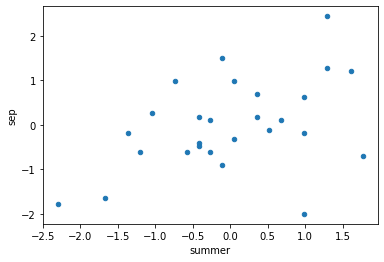

In [0]:
explained_var = X[["summer", "sep"]].var(axis=0).sum() / X.var(axis=0).sum() 

print("% Variance Explained:", explained_var, end="\n\n")
df_bordeaux.plot.scatter(x="summer", y="sep")

Additionally, if we look below, using only two features has hindered our predictive accuracy. This sucks! Fortunately, some very clever mathematicians came up with ways to get around this. 

In [0]:
reg = LinearRegression()

reg.fit(X, y)
print("All Features:\t\t", reg.score(X, y))
reg.fit(X[["summer", "sep"]], y)
print("With PCA Features:\t", reg.score(X[["summer", "sep"]], y), end="\n\n")

All Features:		 0.7526018827767169
With PCA Features:	 0.4633153344681292



## Dimensionality Reduction

With feature selection, we were only able to capture 33% of the original variance, which isn't great. To capture more variation while still remaining in two variables, have to utilize some clever math.

These clever mathematical techniques are known as feature creation, where we try to create new variables that helps us visualize higher dimensional data. There are many different techniques for dimensionality reduction all of which attempts to accomplish different things. Let's start off with the simplest and most popular one: **Principle Component Analysis**.

### Principle Component Analysis (PCA)

Simply put, Principle Component Analysis create new features that maximizes variation. What PCA is **not** doing is feature selection, rather it is creating an entirely new arbitrary feature that is a combination of all the features. 

PCA involves some simple linear algebra, but SciKit-Learn has a PCA implementation. Note that all dimensionality reduction algorithms in SciKit-Learn is operated very similarity to machine learning algorithms you learned in the previous chapters. Create the object and then run `fit()` or `fit_transform()`.

In [0]:
from sklearn.decomposition import PCA

# We want to be able to plot this on a 2-D scatter plot so we choose 2 Dimensions
dimension_we_want = 2

pca = PCA(n_components=dimension_we_want)
X_2d = pca.fit_transform(X) 
X_2d = pd.DataFrame(X_2d, columns=["PCA1", "PCA2"])

print("\n% Variance Explained:", pca.explained_variance_ratio_.sum(), end="\n\n")
X_2d.head()


% Variance Explained: 0.6462543462926849



,PCA1,PCA2
0,2.620822,-1.437859
1,2.166446,0.732196
2,2.359265,-0.067934
3,1.518218,-0.792417
4,1.519920,0.451721


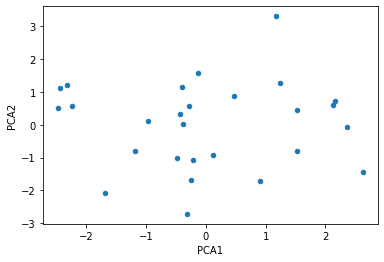

In [0]:
X_2d.plot.scatter(x="PCA1", y="PCA2")

As we can see from above, the two new features (known as Principle Components) are not like any of our input features. Additionally, these two new components explains 64.6% of all the original variation. Let's see how well this performs in explaining our dataset.

In [0]:
reg = LinearRegression()

reg.fit(X, y)
print("All Features:\t\t", reg.score(X, y))
reg.fit(X_2d, y)
print("With PCA Features:\t", reg.score(X_2d, y), end="\n\n")

As expected, with a higher explained variance ratio, we perform better in predicting the quality of the wine. With Dimensionality Reduction, we were able to capture most of the variation in the dataset while still being able to view it in two dimensions. In the most basic of terms, PCA creates a variable projected along the axis of maximum variable.

![](https://raw.githubusercontent.com/bfkwong/data/master/IMG_0187%202.jpg)

### Optional: Linear Algebra Behind PCA

Principle Component Analysis chooses principle components along te **axis of greatest variance**. In Linear Algebra terms, the axis of greatest variance is the **Eigenvector with the largest Eigenvalue of the covariance matrix ($\Sigma$)**

The following are the steps in order to do PCA manually. 

1. Given data matrix $M$, generate the covariance matrix of $M$ denoted as $\Sigma$
2. We then compute the Eigenvector and Eigenvalue of covariance matrix $\Sigma$
3. Project the features to the Eigenvector with the largest Eigenvalue using the dot product (cross product for more than 1 dimensions)

In [0]:
import numpy as np

# Step 1: Calculate covariance matrix 
cov_mtrx = np.cov(X.T)

# Step 2: Calculate Eigenvector and Eigenvalue
W,v = np.linalg.eig(cov_mtrx)

# Step 3: Find the largest Eigenvalue and project our data onto the corresponding Eigenvector
idx_largest_eigenval = np.argmax(W)
eigenvec = v[:,idx_largest_eigenval]

total = []
for row in X.index: 
    total.append(np.dot(X.loc[row], eigenvec))

pd.DataFrame(pd.Series(total), columns=["PCA1"]).head()

One interesting thing you may see here is that the eigenvalue corresponds to the variance explained by its corresponding eigenvalue. The eigenvalue of PCA1 is 2.26 and the variance of PCA1 is also 2.26

In [0]:
idx_largest_eigenval = np.argmax(W)
variance = pd.Series(total).var()

print("Largest Eigenvalue:\t", W[idx_largest_eigenval])
print("Variance of Eigenvector:", variance)

### Multidimensional Scaling (MDS)

We now pay a visit to our good friend, the Euclidean distance. One incredibly useful aspect of Euclidean distance is that it works in higher dimensions. The formula $$\sqrt{x_1^2 + x_2^2}$$ is for two dimensional Euclidean distance, but to move it to a third dimension, it is as easy as adding a $x^3$ variable. One thing to recognize is that Euclidean distance in all dimension is still a number. 

Why am I rambling on about something you learned in middle school? Well the realization that Euclidean distance is scalar in all dimensions means that we can preserve the variance of n-th dimensional data in two dimensions as long as we try to ensure that the Euclidean distances in the n-th dimensional is proportion to the Euclidean distance in 2 dimensions. That was a lot to take in, the following image explains the concept.

![](https://raw.githubusercontent.com/bfkwong/data/master/IMG_0188.jpg)

Notice how when we reduced our dimensions from 2 to 1, the distances between points A, B, and C remained the same. Meaning that x, y, and z remained the same between the two dimensions. While distances may not always be preserved perfectly between dimensions, MDS attempts to preserve it as well as possible.  

In [0]:
from sklearn.manifold import MDS
# We want to be able to plot this on a 2-D scatter plot so we choose 2 Dimensions
dimension_we_want = 2

mds = MDS(n_components=dimension_we_want)
X_2d = mds.fit_transform(X) 
X_2d = pd.DataFrame(X_2d, columns=["Dimension 1", "Dimension 2"])

display(X_2d.head())
print("Percentage variance explained:", X_2d.var().sum()/X.var().sum())
X_2d.plot.scatter(x="Dimension 1", y="Dimension 2")

By using MDS, we were actually able to preserve over 95% of the variance from the original datasets. 

### Linear vs Nonlinear Dimensionality Reduction 

Thus far, we have explored PCA (a linear reduction technique) and MDS (a nonlinear reduction technique). While there are a lot of differences between the two methods. The key differences could be boiled down to just the following statement: **linear dimensionality reduction technique only stretch and shift the data while nonlinear techniques make more drastic changes to the data**.

This sometimes leads to nonlinear techniques being better at capturing variance but losing the overall shape of the data whereas linear techniques are better at keeping the general shape of the original data but loses more variance along the way. 

# Exercises

1. Consider the Iris dataset (https://raw.githubusercontent.com/dlsun/pods/master/data/iris.csv). Drop the "SepalWidth" and "PedalWidth" columns and then apply PCA on "SepalLength" and "PedalLength" with `n_components = 2`. How many percent of the variance was PCA able to capture in this case? What happens when we use PCA to compress 2D data into 2D data?